## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pickle

from datetime import date,timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib notebook

## Import Data

In [2]:
df = pd.read_csv("./input-data/combined.csv")
df2 = pd.read_csv('./input-data/allocation.csv')
df2['year']=pd.to_datetime(df2['year']).dt.year

df2 = df2.groupby('year').sum().reset_index()

df = df.fillna(0)
df = df[(df["gdp"] != 0)]

df = df.merge(df2, how="left")
df.index = pd.Index(pd.date_range("2010", periods = len(df), freq = 'Q'))

In [3]:
for i in df:
    if (df[i].dtypes == float) | (df[i].dtypes == int):
        df[i]=df[i].fillna(df[i].mean())

In [4]:
df[-1:]

,year,quarter,overnight,cpi,usd,klci,ict_rev,gdp,ict_growth,gdp_growth,allocation,expenditure,allocation_research,expenditure_research,government agency,ipta,ipts,others,overall
2016-06-30,2016,2,3.174286,114.566667,4.013257,1661.685072,17007.0,298521.0,3.9,2.6,38782287.05,973435.6,9076499.55,994435.6,NaN,NaN,NaN,NaN,NaN


## Preparation for Model

In [5]:
y = ['gdp']
x = ['overnight','cpi','usd','klci','allocation','year','quarter']

In [6]:
for index, dtype in enumerate(df.dtypes):
    if dtype==np.int64 and df.columns[index] in x+y:
        df[df.columns[index]] = df[df.columns[index]].astype(float)

In [7]:
df.dtypes

year                    float64
quarter                 float64
overnight               float64
cpi                     float64
usd                     float64
klci                    float64
ict_rev                 float64
gdp                     float64
ict_growth              float64
gdp_growth              float64
allocation              float64
expenditure             float64
allocation_research     float64
expenditure_research    float64
government agency       float64
ipta                    float64
ipts                    float64
others                  float64
overall                 float64
dtype: object

In [8]:
exogx = np.column_stack([df[x]])

## Arima Model with Exogenous Variables

In [9]:
fit = sm.tsa.ARIMA(df[y], (1,0,1), exog = exogx).fit()

## Save Model

In [10]:
with open('gdp_model.pkl', 'wb') as fid:
    pickle.dump(fit, fid)    

## Predict with Model

In [11]:
def gdp_predict(numberOfPoints, overnightInterest, cpi, usd, klciIndex, fund):
    
    with open('./gdp_model.pkl', 'rb') as fid:
        fit = pickle.load(fid)
    
    data = [[overnightInterest, cpi, usd, klciIndex, fund]]
    data = np.repeat(data, numberOfPoints, axis=0)
    
    base_overnightInterest = 3.174286
    base_cpi = 114.566667
    base_usd = 4.013257
    base_klciIndex = 1661.685072
    base_Fund = 38782287.05
    diff_overnightInterest=(overnightInterest-base_overnightInterest)/numberOfPoints
    diff_cpi=(cpi-base_cpi)/numberOfPoints
    diff_usd=(usd-base_usd)/numberOfPoints
    diff_klciIndex=(klciIndex-base_klciIndex)/numberOfPoints
    diff_fund=(fund-base_Fund)/numberOfPoints
        
    _list=[]
    year=2016
    quarter=3
    time=date(year,(quarter*3),1)
    for i in range(numberOfPoints):
        base_overnightInterest+=diff_overnightInterest
        base_cpi+=diff_cpi
        base_usd+=diff_usd
        base_klciIndex+=diff_klciIndex
        base_Fund+=diff_fund
        _list.append([base_overnightInterest,base_cpi,base_usd,
                      base_klciIndex,base_Fund,time.year,time.month//3])
        time=time+relativedelta(months=3)
      
        
    pred2 = fit.forecast(steps=numberOfPoints, exog=np.array(_list))
    
    df = pd.DataFrame(data=[pred2[0],pred2[2]]).T
    df.columns = ['GDP','Confident Interval']
    df['confidentIntervalLower'] = df['Confident Interval'].map(lambda x : np.round(x[0],2))
    df['confidentIntervalUpper'] = df['Confident Interval'].map(lambda x : np.round(x[1],2))
    df.drop('Confident Interval', axis=1, inplace=True)
    df['type'] = "Predicted"
    df['date'] = pd.date_range(fit.data.dates[len(fit.data.dates)-1], periods = numberOfPoints+1, freq = 'Q')[1:]
    
    df['increment']=pd.Series([1+(i/10) for i in range(df.shape[0])])
    df['confidentIntervalLower']=df['GDP']-(df['GDP']-df['confidentIntervalLower'])*df['increment']
    df['confidentIntervalUpper']=df['GDP']+(df['confidentIntervalUpper']-df['GDP'])*df['increment']
    df.drop('increment',axis=1,inplace=True)
    
    
    output = pd.DataFrame([fit.data.dates,fit.data.endog]).T
    output.columns = ['date','GDP']
    output['type'] = "Observed"
    output['confidentIntervalLower'] = np.nan
    output['confidentIntervalUpper'] = np.nan
    output = output.append(df).reset_index(drop=True)
    
    return(output)

In [12]:
# sample data
overnightInterest = 3.174286
cpi = 114.566667
usd = 4.013257
klciIndex = 1661.685072
fund = 38782287.05
numberOfPoints = 8

In [13]:
# sample data
overnightInterest = 3.42
cpi = 112.566667
usd = 3.2
klciIndex = 1332.253548
fund = 210000000.05
numberOfPoints = 20

<IPython.core.display.Javascript object>


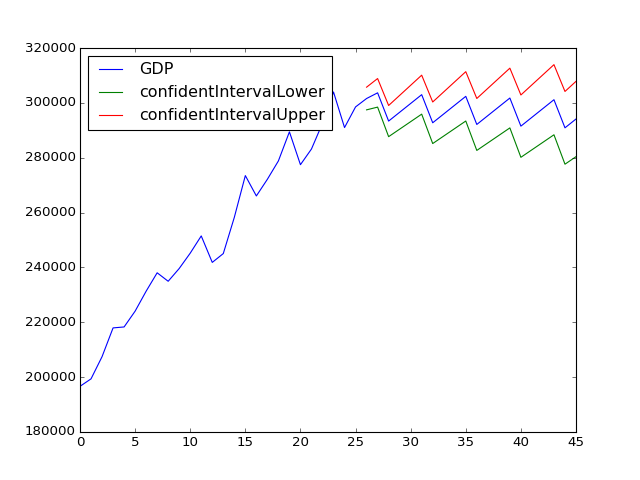

,GDP,confidentIntervalLower,confidentIntervalUpper,date,type
0,196650,NaN,NaN,2010-03-31 00:00:00,Observed
1,199372,NaN,NaN,2010-06-30 00:00:00,Observed
2,207460,NaN,NaN,2010-09-30 00:00:00,Observed
3,217953,NaN,NaN,2010-12-31 00:00:00,Observed
4,218298,NaN,NaN,2011-03-31 00:00:00,Observed
5,224055,NaN,NaN,2011-06-30 00:00:00,Observed
6,231335,NaN,NaN,2011-09-30 00:00:00,Observed
7,238045,NaN,NaN,2011-12-31 00:00:00,Observed
8,234956,NaN,NaN,2012-03-31 00:00:00,Observed
9,239607,NaN,NaN,2012-06-30 00:00:00,Observed


In [14]:
result=gdp_predict(numberOfPoints, overnightInterest, cpi, usd, klciIndex, fund)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

for i in ['GDP','confidentIntervalLower','confidentIntervalUpper']:
    ax1.plot(result[i],label=i)
ax1.legend(loc=2)
result